In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [21]:
# Load Data
company = 'TSLA'

start = dt.datetime(2012,1,1)
end = dt.datetime(2022,1,1)

data = web.DataReader(company, 'yahoo', start, end)

# prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range (prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])
    
    
x_train,y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [22]:
# building the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
#prediction of the next closing vlaue
model.add(Dense(units=1))
          
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

# Test the model accuracy on existing data

# load test data
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


Epoch 1/25
72/72 [==============================] - 6s 37ms/step - loss: 0.0040
Epoch 2/25
72/72 [==============================] - 3s 36ms/step - loss: 0.0013
Epoch 3/25
72/72 [==============================] - 3s 37ms/step - loss: 0.0014
Epoch 4/25
72/72 [==============================] - 3s 38ms/step - loss: 0.0017
Epoch 5/25
72/72 [==============================] - 3s 38ms/step - loss: 0.0011
Epoch 6/25
72/72 [==============================] - 3s 38ms/step - loss: 0.0010
Epoch 7/25
72/72 [==============================] - 3s 38ms/step - loss: 9.1222e-04
Epoch 8/25
72/72 [==============================] - 3s 38ms/step - loss: 8.7004e-04
Epoch 9/25
72/72 [==============================] - 3s 37ms/step - loss: 9.4225e-04
Epoch 10/25
72/72 [==============================] - 3s 38ms/step - loss: 8.4170e-04
Epoch 11/25
72/72 [==============================] - 3s 39ms/step - loss: 7.8389e-04
Epoch 12/25
72/72 [==============================] - 3s 38ms/step - loss: 7.9305e-04
Epoch 13/25
7

In [23]:
#make predictions on test data 
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


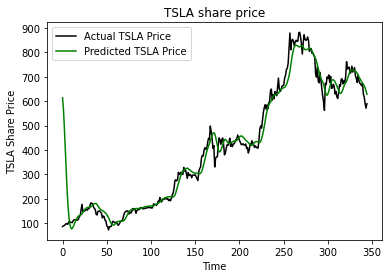

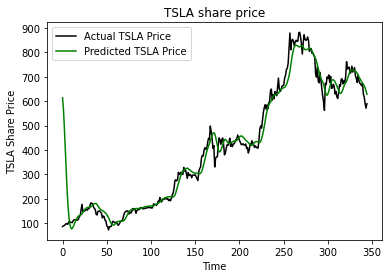

Prediction for tomorrow: $[[614.4679]]


In [34]:
#plot test predictions 
plt.plot(actual_prices, color = "black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color = "green", label = f"Predicted {company} Price")
plt.title(f"{company} share price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

#predict next day 

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction for tomorrow: ${prediction}")